In [1]:
# Input:
path_data = '../../01 data/train_pollution.csv'
target_var = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
n_lag = 3
n_out = 2

path_01 = '../../03 outputs/encoder_decoder/01/'
path_scaler = path_01 + 'time_scaler.pickle'
path_x_train = path_01 + 'X_train.npy'
path_y_train = path_01 + 'y_train.npy'
path_x_val = path_01 + 'X_val.npy'
path_y_val = path_01 + 'y_val.npy'
path_x_test = path_01 + 'X_test.npy'
path_y_test = path_01 + 'y_test.npy'

path_02 = '../../03 outputs/encoder_decoder/02/'
path_forecaster_encoder_decoder = path_02 + 'forecaster_encoder_decoder.hdf5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import pickle
from keras.models import load_model

In [3]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
data = data[
    ['target_carbon_monoxide', 'sensor_1', 'sensor_2', 'sensor_5', 'target_benzene', 'target_nitrogen_oxides']
]
print(data.shape)
data.head(3)

(7111, 6)


,target_carbon_monoxide,sensor_1,sensor_2,sensor_5,target_benzene,target_nitrogen_oxides
0,2.5,1387.2,1087.8,1293.4,12.0,167.7
1,2.1,1279.1,888.2,1010.9,9.9,98.9
2,2.2,1331.9,929.6,1117.0,9.2,127.1


In [4]:
# Load data (lag 3 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))
X_test = np.load(open(path_x_test, 'rb'))
y_test = np.load(open(path_y_test, 'rb'))

In [5]:
# Load model and tokenizer
scaler = pickle.load(open(path_scaler, 'rb'))

forecaster_encoder_decoder = load_model(path_forecaster_encoder_decoder)

In [6]:
def transform_back(pred, suffix):
    pred = scaler.inverse_transform(pred)
    column_name = [v + f'{suffix}' for v in target_var]
    pred = pd.DataFrame(pred, columns=column_name)
    return pred

In [7]:
# Forecast train
pred_train = forecaster_encoder_decoder.predict(X_train, verbose=0)
pred_train_0 = transform_back(pred_train[:,0], '(t)')
pred_train_1 = transform_back(pred_train[:,1], '(t+1)')
pred_train = pd.concat([pred_train_0, pred_train_1], axis=1)

# Forecast val
pred_val = forecaster_encoder_decoder.predict(X_val, verbose=0)
pred_val_0 = transform_back(pred_val[:,0], '(t)')
pred_val_1 = transform_back(pred_val[:,1], '(t+1)')
pred_val = pd.concat([pred_val_0, pred_val_1], axis=1)

# Forecast test
pred_test = forecaster_encoder_decoder.predict(X_test, verbose=0)
pred_test_0 = transform_back(pred_test[:,0], '(t)')
pred_test_1 = transform_back(pred_test[:,1], '(t+1)')
pred_test = pd.concat([pred_test_0, pred_test_1], axis=1)

In [8]:
# Combine predictions
pred_train['split'] = 'train'
pred_val['split'] = 'val'
pred_test['split'] = 'test'

pred = pd.concat([pred_train, pred_val, pred_test], axis=0).reset_index(drop=True)
pred.index = pred.index + n_lag
pred.columns = ['prediction ' + c if c != 'split' else c for c in pred.columns ]

# Combine with original data
pred = pd.concat([data[target_var], pred], axis=1)
columns_names = [f'{v}(t+1)' for v in target_var]
pred[columns_names] = pred[target_var].shift(1)
print(pred.shape)
pred.head(7)

(7111, 13)


,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,prediction target_carbon_monoxide(t),prediction target_benzene(t),prediction target_nitrogen_oxides(t),prediction target_carbon_monoxide(t+1),prediction target_benzene(t+1),prediction target_nitrogen_oxides(t+1),split,target_carbon_monoxide(t+1),target_benzene(t+1),target_nitrogen_oxides(t+1)
0,2.5,12.0,167.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.1,9.9,98.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,12.0,167.7
2,2.2,9.2,127.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,9.9,98.9
3,2.2,9.7,177.2,1.939321,9.638759,111.767960,1.950694,9.225467,104.065216,train,2.2,9.2,127.1
4,1.5,6.4,121.8,2.138036,10.526649,133.108673,2.234822,10.378582,132.744354,train,2.2,9.7,177.2
5,1.2,4.4,88.1,1.502782,6.894829,108.095955,1.425569,5.941783,100.985497,train,1.5,6.4,121.8
6,1.2,3.7,59.5,1.158393,4.878459,90.900330,0.988009,3.534436,80.885132,train,1.2,4.4,88.1


In [9]:
# Check the split boundary
train_split = pred[pred['split']=='train'].index[-1]
val_split = pred[pred['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


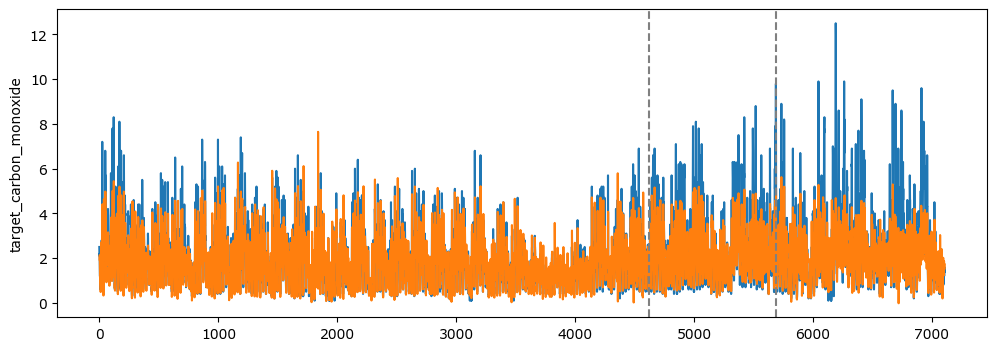

In [10]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred, x=pred.index, y='target_carbon_monoxide')
sns.lineplot(pred, x=pred.index, y='prediction target_carbon_monoxide(t)')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

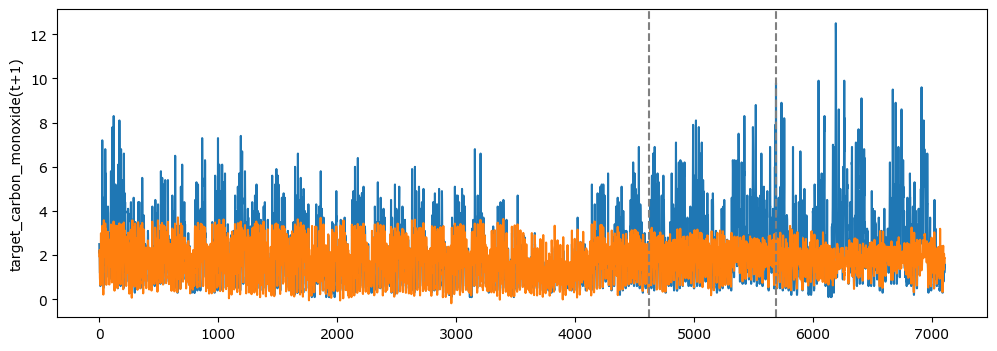

In [11]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred, x=pred.index, y='target_carbon_monoxide(t+1)')
sns.lineplot(pred, x=pred.index, y='prediction target_carbon_monoxide(t+1)')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

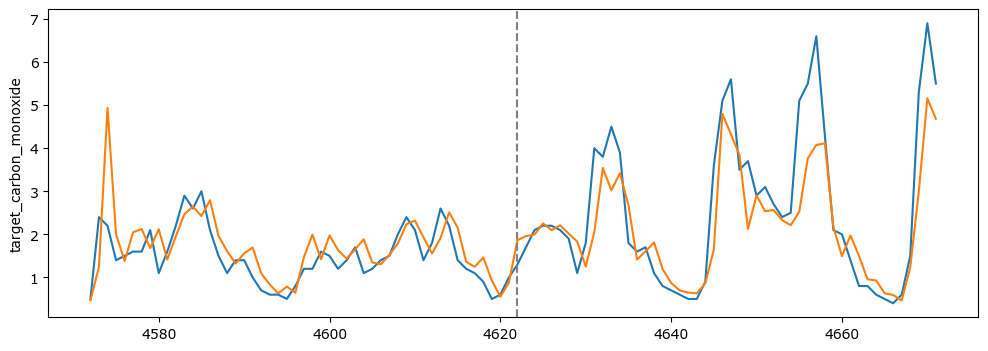

In [13]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred.iloc[train_split-50:train_split+50,:], x=pred.iloc[train_split-50:train_split+50,:].index, y='target_carbon_monoxide')
sns.lineplot(pred.iloc[train_split-50:train_split+50,:], x=pred.iloc[train_split-50:train_split+50,:].index, y='prediction target_carbon_monoxide(t)')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [21]:
# Accuracy
def model_evaluation(true_column, prediction_column):
    mae_train = round(mean_absolute_error(pred.loc[pred['split']=='train', true_column], pred.loc[pred['split']=='train', prediction_column]), 4)
    mae_val = round(mean_absolute_error(pred.loc[pred['split']=='val', true_column], pred.loc[pred['split']=='val', prediction_column]), 4)
    mae_test = round(mean_absolute_error(pred.loc[pred['split']=='test', true_column], pred.loc[pred['split']=='test', prediction_column]), 4)
    print(f'training MAE: {mae_train}')
    print(f'validation MAE: {mae_val}')
    print(f'testing MAE: {mae_test}')
    print(f'std: ' + str(round(pred[pred['split']=='train'][true_column].std(),3)))

In [22]:
print('target_carbon_monoxide')
print('first step')
model_evaluation('target_carbon_monoxide', 'prediction target_carbon_monoxide(t)')

print('')
print('second step')
model_evaluation('target_carbon_monoxide(t+1)', 'prediction target_carbon_monoxide(t+1)')

target_carbon_monoxide
first step
training MAE: 0.4364
validation MAE: 0.6345
testing MAE: 0.8195
std: 1.192

second step
training MAE: 0.4669
validation MAE: 0.9751
testing MAE: 1.2519
std: 1.192


In [23]:
print('target_benzene')
print('first step')
model_evaluation('target_benzene', 'prediction target_benzene(t)')

print('')
print('second step')
model_evaluation('target_benzene(t+1)', 'prediction target_benzene(t+1)')

target_benzene
first step
training MAE: 2.362
validation MAE: 3.6655
testing MAE: 3.586
std: 6.69

second step
training MAE: 2.5414
validation MAE: 5.0267
testing MAE: 4.9872
std: 6.69


In [24]:
print('target_nitrogen_oxides')
print('first step')
model_evaluation('target_nitrogen_oxides', 'prediction target_nitrogen_oxides(t)')

print('')
print('second step')
model_evaluation('target_nitrogen_oxides(t+1)', 'prediction target_nitrogen_oxides(t+1)')

target_nitrogen_oxides
first step
training MAE: 30.0382
validation MAE: 73.0875
testing MAE: 103.7278
std: 89.556

second step
training MAE: 32.026
validation MAE: 91.6358
testing MAE: 158.7151
std: 89.553


In [19]:
# Save
pred.to_csv('../../03 outputs/encoder_decoder/03/prediction.csv')